In [2]:
from typing import List, Tuple, Optional, Sequence, Union

import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.result import Result
from qiskit.transpiler import Target
from qiskit import transpile


from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError
#from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend


In [5]:
import pandas as pd
import numpy as np

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit import IBMQ, schedule

In [3]:
import datetime
from itertools import chain
from typing import Dict, List, Optional, Tuple, Union

import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.library.standard_gates import RZGate, SXGate, XGate
from qiskit.circuit.measure import Measure
from qiskit.circuit.parameter import Parameter
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.models import PulseDefaults
from qiskit.providers.models.pulsedefaults import Command
from qiskit.providers.options import Options
from qiskit.pulse import Schedule, ScheduleBlock
from qiskit.pulse.transforms import block_to_schedule
from qiskit.qobj.pulse_qobj import PulseQobjInstruction
from qiskit.qobj.utils import MeasLevel, MeasReturnType
from qiskit.quantum_info.states import DensityMatrix, Statevector
from qiskit.result import Result
from qiskit.transpiler import InstructionProperties, Target

from qiskit_dynamics import Solver
from qiskit_dynamics.pulse import InstructionToSignals

from qiskit_experiments.exceptions import QiskitError
from qiskit_experiments.test.utils import FakeJob


# TODO: add some discrimination for IQ data to counts to capture misclassified leakage shots.
class IQPulseBackend(BackendV2):
    """Abstract base class for pulse simulation backends.

    This backend is designed for the tests in Qiskit Experiments as well as for the
    tutorials in Qiskit Experiments.
    """

    def __init__(
        self,
        static_hamiltonian: np.ndarray,
        hamiltonian_operators: np.ndarray,
        static_dissipators: Optional[np.ndarray] = None,
        dt: float = 0.1 * 1e-9,
        solver_method="RK23",
        **kwargs,
    ):
        """Initialize backend with model information.

        Args:
            static_hamiltonian: Time-independent term in the Hamiltonian.
            hamiltonian_operators: List of time-dependent operators
            static_dissipators: Constant dissipation operators. Defaults to None.
            dt: Sample rate for simulating pulse schedules. Defaults to 0.1*1e-9.
            solver_method: Numerical solver method to use. Check qiskit_dynamics for available
                methods. Defaults to "RK23".
        """
        super().__init__(
            None,
            name="PulseBackendV2",
            description="A PulseBackend simulator",
            online_date=datetime.datetime.utcnow(),
            backend_version="0.0.1",
        )
        self._defaults = PulseDefaults.from_dict(
            {
                "qubit_freq_est": [0],
                "meas_freq_est": [0],
                "buffer": 0,
                "pulse_library": [],
                "cmd_def": [],
            }
        )
        self._rng = np.random.default_rng(0)

        # The instance to convert pulse schedules to signals for Qiskit Dynamics.
        self.converter = None

        self.solver_method = solver_method

        self.static_hamiltonian = static_hamiltonian
        self.hamiltonian_operators = hamiltonian_operators
        self.static_dissipators = static_dissipators
        self.solver = Solver(
            static_hamiltonian=self.static_hamiltonian,
            hamiltonian_operators=self.hamiltonian_operators,
            static_dissipators=self.static_dissipators,
            **kwargs,
        )
        self._target = Target(dt=dt, granularity=16)

        self.model_dim = self.solver.model.dim

        if self.static_dissipators is None:
            self.y_0 = np.eye(self.model_dim)
            self.gs = np.array([1.0] + [0.0] * (self.model_dim - 1))
        else:
            self.y_0 = np.eye(self.model_dim**2)
            self.gs = np.array([1.0] + [0.0] * (self.model_dim**2 - 1))

        self._simulated_pulse_unitaries = {}

        # An internal cache of schedules to unitaries. The key is a hashed string representation.
        self._schedule_cache = {}

    @property
    def target(self):
        """Contains information for circuit transpilation"""
        return self._target

    @property
    def max_circuits(self):
        return None

    def defaults(self):
        """return backend pulse defaults"""
        return self._defaults

    @classmethod
    def _default_options(cls) -> Options:
        """Returns the default options of the backend."""
        return Options(
            shots=4000,
            meas_level=MeasLevel.CLASSIFIED,
            meas_return=MeasReturnType.AVERAGE,
        )

    @property
    def default_pulse_unitaries(self) -> Dict[Tuple, np.array]:
        """Return the default unitary matrices of the backend."""
        return self._simulated_pulse_unitaries

    @default_pulse_unitaries.setter
    def default_pulse_unitaries(self, unitaries: Dict[Tuple, np.array]):
        """Set the default unitary pulses this allows the tests to simulate the pulses only once."""
        self._simulated_pulse_unitaries = unitaries

    @staticmethod
    def _get_info(
        circuit: QuantumCircuit, instruction: CircuitInstruction
    ) -> Tuple[Tuple[int], Tuple[float], str]:
        """Returns information that uniquely describes a circuit instruction.

        Args:
            circuit: The quantum circuit in which the instruction is located. This is needed to
                access the register in the circuit.
            instruction: A gate or operation in a QuantumCircuit

        Returns:
            Tuple of qubit index, gate parameters and instruction name.
        """
        p_dict = instruction.operation
        qubit = tuple(int(circuit.qregs[0].index(qbit)) for qbit in instruction.qubits)
        params = tuple(float(val) for val in p_dict.params)
        return qubit, params, p_dict.name

    def iq_data(
        self,
        probability: np.ndarray,
        shots: int,
        centers: List[Tuple[float, float]],
        width: float,
        phase: Optional[float] = None,
    ) -> Tuple[List, List]:
        """Generates IQ data for each physical level.

        Args:
            probability: probability of occupation
            shots: Number of shots
            centers: The central i and q points for each level
            width: Width of IQ data distribution
            phase: Phase of IQ data, by default 0. Defaults to None.

        Returns:
            (I,Q) data.
        """
        counts_n = np.random.multinomial(shots, probability / sum(probability), size=1).T

        full_i, full_q = [], []

        for idx, count_i in enumerate(counts_n):
            full_i.append(np.random.normal(loc=centers[idx][0], scale=width, size=count_i))
            full_q.append(np.random.normal(loc=centers[idx][1], scale=width, size=count_i))

        full_i = list(chain.from_iterable(full_i))
        full_q = list(chain.from_iterable(full_q))

        if phase is not None:
            complex_iq = (full_i + 1.0j * full_q) * np.exp(1.0j * phase)
            full_i, full_q = complex_iq.real, complex_iq.imag

        full_iq = 1e16 * np.array([[full_i], [full_q]]).T
        return full_iq.tolist()

    def iq_cluster_centers(self, circuit: Optional[QuantumCircuit] = None):
        """A function to provide the points for the IQ centers when doing readout.

        Subclasses can override this function, for instance, to provide circuit dependent
        IQ cluster centers. If this function is not overridden then the IQ cluster centers returned
        are evenly distributed on the unit sphere in the IQ plane with |0> located at IQ point (0, 1).

        Args:
            The circuit is provided so that sub-classes that implement their own IQ simulation
                by overriding this method can access circuit-level data (e.g. for
                ReadoutSpectroscopy simulation).
        """
        theta = 2 * np.pi / self.model_dim
        return [(np.cos(idx * theta), np.sin(idx * theta)) for idx in range(self.model_dim)]

    def _state_to_measurement_data(
        self,
        state: np.ndarray,
        shots: int,
        meas_level: MeasLevel,
        meas_return: MeasReturnType,
        circuit: QuantumCircuit,
    ) -> Union[Dict[str, int], np.ndarray]:
        """Convert State operator objects to IQ data or Counts.

        TODO we could implement discrimination here.

        Args:
            state: Quantum state information.
            shots: Number of repetitions of each circuit, for sampling.
            meas_level: Measurement level 1 returns IQ data. 2 returns counts.
            meas_return: "single" returns information from every shot. "avg" returns average
                          measurement output (averaged over number of shots).
            circuit: The circuit is provided so that :meth:`iq_data` can leverage any circuit-level
                information that it might need to generate the IQ shots.

        Returns:
            Measurement Output.
        """
        if self.static_dissipators is not None:
            state = state.reshape(self.model_dim, self.model_dim)
            state = DensityMatrix(state / np.trace(state))
        else:
            state = Statevector(state / np.linalg.norm(state))

        if meas_level == MeasLevel.CLASSIFIED:
            measurement_data = state.sample_counts(shots)

        elif meas_level == MeasLevel.KERNELED:
            centers = self.iq_cluster_centers(circuit=circuit)
            measurement_data = self.iq_data(state.probabilities(), shots, centers, 0.2)
            if meas_return == "avg":
                measurement_data = np.average(np.array(measurement_data), axis=0)
        else:
            raise QiskitError(f"Unsupported measurement level {meas_level}.")

        return measurement_data

    def solve(self, schedule: Union[ScheduleBlock, Schedule], qubits: Tuple[int]) -> np.ndarray:
        """Solves for qubit dynamics under the action of a pulse instruction

        Args:
            schedule: Pulse signal
            qubits: (remove after multi-qubit gates is implemented)

        Returns:
            Time-evolution unitary operator
        """
        if len(qubits) > 1:
            QiskitError("Multi qubit gates are not yet implemented.")

        if isinstance(schedule, ScheduleBlock):
            schedule = block_to_schedule(schedule)

        signal = self.converter.get_signals(schedule)
        time_f = schedule.duration * self.dt
        unitary = self.solver.solve(
            t_span=[0.0, time_f],
            y0=self.y_0,
            t_eval=[time_f],
            signals=signal,
            method=self.solver_method,
        ).y[0]

        return unitary

    def run(self, run_input: Union[QuantumCircuit, List[QuantumCircuit]], **run_options) -> FakeJob:
        """run method takes circuits as input and returns FakeJob with IQ data or counts.

        Args:
            run_input: Circuits to run

        Returns:
            FakeJob with simulation data.
        """
        self.options.update_options(**run_options)
        shots = self.options.get("shots", self._options.shots)
        meas_level = self.options.get("meas_level", self._options.meas_level)
        meas_return = self.options.get("meas_return", self._options.meas_return)

        result = {
            "backend_name": f"{self.__class__.__name__}",
            "backend_version": self.backend_version,
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "results": [],
        }

        if isinstance(run_input, QuantumCircuit):
            run_input = [run_input]

        for circuit in run_input:
            unitaries = {}

            # 1. Parse the calibrations and simulate any new schedule. Add U to the unitaries.
            for name, schedule in circuit.calibrations.items():
                for (qubits, params), schedule_block in schedule.items():
                    schedule_key = hash(repr(schedule))

                    # Simulate the schedule if not in the cache.
                    if schedule_key not in self._schedule_cache:
                        self._schedule_cache[schedule_key] = self.solve(schedule_block, qubits)

                    unitaries[(name, qubits, params)] = self._schedule_cache[schedule_key]

            # 2. Copy over any remaining instructions to the dict of unitaries.
            for key, unitary in self.default_pulse_unitaries.items():
                if key not in unitaries:
                    unitaries[key] = unitary

            # 3. Multiply the unitaries of the circuit instructions onto the ground state.
            state_t = self.gs.copy()
            for instruction in circuit.data:
                qubits, params, inst_name = self._get_info(circuit, instruction)
                if inst_name in ["barrier", "measure"]:
                    continue
                if inst_name == "rz":
                    # Ensures that the action in the qubit space is preserved.
                    unitary = np.diag([np.exp(1.0j * idx * params[0] / 2) for idx in [-1, 1, 3]])
                else:
                    unitary = unitaries[(inst_name, qubits, params)]
                state_t = unitary @ state_t

            # 4. Convert the probabilities to IQ data or counts.
            return_data = self._state_to_measurement_data(
                state_t, shots, meas_level, meas_return, circuit
            )

            run_result = {
                "shots": shots,
                "success": True,
                "header": {"metadata": circuit.metadata},
                "meas_level": meas_level,
                "meas_return": meas_return,
                "data": {},
            }

            if meas_level == MeasLevel.CLASSIFIED:
                run_result["data"]["counts"] = return_data
            if meas_level == MeasLevel.KERNELED:
                run_result["data"]["memory"] = return_data

            result["results"].append(run_result)

        return FakeJob(self, Result.from_dict(result))


class SingleTransmonTestBackend(IQPulseBackend):
    r"""Three level anharmonic transmon qubit.
    .. math::
        H = \hbar \sum_{j=1,2} \left[\omega_j \Pi_j +
                \mathcal{E}(t) \lambda_j (\sigma_j^+ + \sigma_j^-)\right]
    """

    def __init__(
        self,
        qubit_frequency: float = 5e9,
        anharmonicity: float = -0.25e9,
        lambda_1: float = 1e9,
        lambda_2: float = 0.8e9,
        gamma_1: float = 1e4,
        noise: bool = True,
        **kwargs,
    ):
        """Initialise backend with hamiltonian parameters

        Args:
            qubit_frequency: Frequency of the qubit (0-1). Defaults to 5e9.
            anharmonicity: Qubit anharmonicity $\\alpha$ = f12 - f01. Defaults to -0.25e9.
            lambda_1: Strength of 0-1 transition. Defaults to 1e9.
            lambda_2: Strength of 1-2 transition. Defaults to 0.8e9.
            gamma_1: Relaxation rate (1/T1) for 1-0. Defaults to 1e4.
            noise: . Defaults to True.
        """
        qubit_frequency_02 = 2 * qubit_frequency + anharmonicity
        ket0 = np.array([[1, 0, 0]]).T
        ket1 = np.array([[0, 1, 0]]).T
        ket2 = np.array([[0, 0, 1]]).T

        sigma_m1 = ket0 @ ket1.T.conj()
        sigma_m2 = ket1 @ ket2.T.conj()

        sigma_p1 = sigma_m1.T.conj()
        sigma_p2 = sigma_m2.T.conj()

        p1 = ket1 @ ket1.T.conj()
        p2 = ket2 @ ket2.T.conj()

        drift = 2 * np.pi * (qubit_frequency * p1 + qubit_frequency_02 * p2)
        control = [
            2 * np.pi * (lambda_1 * (sigma_p1 + sigma_m1) + lambda_2 * (sigma_p2 + sigma_m2))
        ]
        r_frame = 2 * np.pi * qubit_frequency * (p1 + 2 * p2)
        t1_dissipator = np.sqrt(gamma_1) * sigma_m1

        self.anharmonicity = anharmonicity
        self.rabi_rate_01 = 8.589
        self.rabi_rate_12 = 6.876

        if noise is True:
            evaluation_mode = "dense_vectorized"
            static_dissipators = [t1_dissipator]
        else:
            evaluation_mode = "dense"
            static_dissipators = None

        super().__init__(
            static_hamiltonian=drift,
            hamiltonian_operators=control,
            static_dissipators=static_dissipators,
            rotating_frame=r_frame,
            rwa_cutoff_freq=1.9 * qubit_frequency,
            rwa_carrier_freqs=[qubit_frequency],
            evaluation_mode=evaluation_mode,
            **kwargs,
        )

        self._defaults = PulseDefaults.from_dict(
            {
                "qubit_freq_est": [qubit_frequency / 1e9],
                "meas_freq_est": [0],
                "buffer": 0,
                "pulse_library": [],
                "cmd_def": [
                    Command.from_dict(
                        {
                            "name": "x",
                            "qubits": [0],
                            "sequence": [
                                PulseQobjInstruction(
                                    name="parametric_pulse",
                                    t0=0,
                                    ch="d0",
                                    label="Xp_d0",
                                    pulse_shape="drag",
                                    parameters={
                                        "amp": (0.5 + 0j) / self.rabi_rate_01,
                                        "beta": 5,
                                        "duration": 160,
                                        "sigma": 40,
                                    },
                                ).to_dict()
                            ],
                        }
                    ).to_dict(),
                    Command.from_dict(
                        {
                            "name": "sx",
                            "qubits": [0],
                            "sequence": [
                                PulseQobjInstruction(
                                    name="parametric_pulse",
                                    t0=0,
                                    ch="d0",
                                    label="X90p_d0",
                                    pulse_shape="drag",
                                    parameters={
                                        "amp": (0.25 + 0j) / self.rabi_rate_01,
                                        "beta": 5,
                                        "duration": 160,
                                        "sigma": 40,
                                    },
                                ).to_dict()
                            ],
                        }
                    ).to_dict(),
                ],
            }
        )
        self._target = Target(
            qubit_properties=[QubitProperties(frequency=qubit_frequency)],
            dt=self.dt,
            granularity=16,
        )

        measure_props = {
            (0,): InstructionProperties(duration=0, error=0),
        }
        x_props = {
            (0,): InstructionProperties(duration=160e-10, error=0),
        }
        sx_props = {
            (0,): InstructionProperties(duration=160e-10, error=0),
        }
        rz_props = {
            (0,): InstructionProperties(duration=0.0, error=0),
        }
        self._phi = Parameter("phi")
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(self._phi), rz_props)

        self.converter = InstructionToSignals(self.dt, carriers={"d0": qubit_frequency})

        default_schedules = [
            self._defaults.instruction_schedule_map.get("x", (0,)),
            self._defaults.instruction_schedule_map.get("sx", (0,)),
        ]
        self._simulated_pulse_unitaries = {
            (schedule.name, (0,), ()): self.solve(schedule, (0,)) for schedule in default_schedules
        }

In [9]:
backend = SingleTransmonTestBackend(5.0e9,-.25e9, 1e9, 0.8e9, noise=False)
qubit = 0 

In [10]:
def setup_cals(backend) -> Calibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp, num_qubits=1)
    cals.add_schedule(xm, num_qubits=1)
    cals.add_schedule(x90p, num_qubits=1)

    return cals

def add_parameter_guesses(cals: Calibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

In [11]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

In [12]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

In [13]:
library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = Calibrations.from_backend(backend, libraries=[library])

# Spectroscopy

In [14]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal

In [15]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,duration,(),x,3.200000e+02,default,True,2022-11-24 10:08:07.452283+0900,None
1,amp,(),x,5.000000e-01,default,True,2022-11-24 10:08:07.452085+0900,None
2,β,(),sx,0.000000e+00,default,True,2022-11-24 10:08:07.452283+0900,None
3,duration,(),sx,3.200000e+02,default,True,2022-11-24 10:08:07.452283+0900,None
4,amp,(),sx,2.500000e-01,default,True,2022-11-24 10:08:07.452283+0900,None
5,σ,(),x,8.000000e+01,default,True,2022-11-24 10:08:07.452283+0900,None
6,β,(),x,0.000000e+00,default,True,2022-11-24 10:08:07.452283+0900,None
7,drive_freq,"(0,)",None,5.000000e+09,default,True,2022-11-24 10:08:07.645403+0900,None
8,σ,(),sx,8.000000e+01,default,True,2022-11-24 10:08:07.452283+0900,None


In [16]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)
spec = RoughFrequencyCal(qubit, cals, frequencies, backend=backend)
spec.set_experiment_options(amp=0.005)

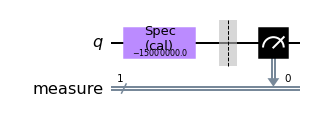

In [19]:
circuit = spec.circuits()[0]
circuit.draw(output="mpl")

In [20]:
schedule(circuit, backend).draw()

NotImplementedError: 

In [21]:
spec_data = spec.run().block_for_results()

c:\Users\kimje\anaconda3\envs\qiskit_JW\lib\site-packages\numpy\lib\function_base.py:2387: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


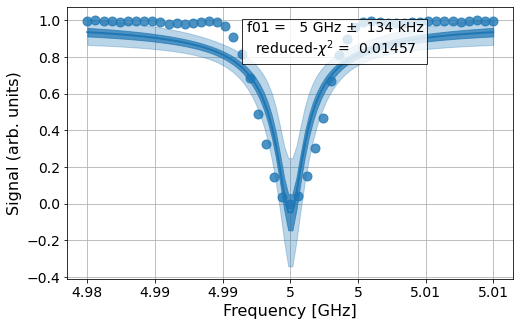

In [22]:
spec_data.figure(0)

In [23]:
print(spec_data.analysis_results("f01"))

AnalysisResult
- name: f01
- value: (5.00000+/-0.00013)e+09
- χ²: 0.014569627862315799
- quality: good
- extra: <1 items>
- device_components: ['Q0']
- verified: False


In [24]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,drive_freq,"(0,)",None,5.000001e+09,default,True,2022-11-24 10:09:59.424914+0900,82cb4cd3-942a-4495-a923-8338f18c8a08


# Rabi

In [25]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

In [26]:
rabi = RoughXSXAmplitudeCal(qubit, cals, backend=backend, amplitudes=np.linspace(-0.1, 0.1, 51))

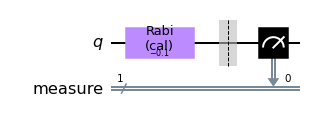

In [27]:
rabi.circuits()[0].draw("mpl")

In [28]:
rabi_data = rabi.run().block_for_results()

c:\Users\kimje\anaconda3\envs\qiskit_JW\lib\site-packages\numpy\lib\function_base.py:2387: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


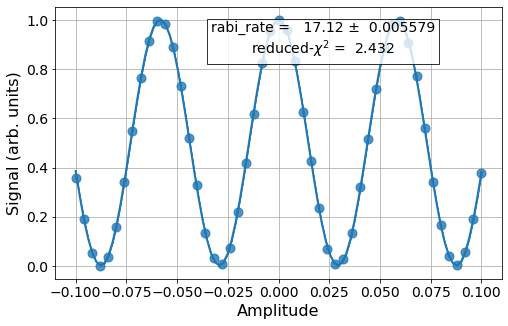

In [29]:
rabi_data.figure(0)

In [30]:
print(rabi_data.analysis_results("rabi_rate"))

AnalysisResult
- name: rabi_rate
- value: 17.119+/-0.006
- χ²: 2.4317759490097193
- quality: bad
- device_components: ['Q0']
- verified: False


In [31]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,(),x,0.500000+0.000000j,default,True,2022-11-24 10:08:07.452085+0900,None
1,amp,"(0,)",sx,0.014604+0.000000j,default,True,2022-11-24 10:14:41.357339+0900,6edba754-60aa-42ff-b98d-ec2d11dd5652
2,amp,"(0,)",x,0.029208+0.000000j,default,True,2022-11-24 10:14:41.351304+0900,6edba754-60aa-42ff-b98d-ec2d11dd5652
3,amp,(),sx,0.250000+0.000000j,default,True,2022-11-24 10:08:07.452283+0900,None


In [32]:
cals.get_schedule("sx", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.01460407+0j), sigma=80, beta=0), DriveChannel(0)), name="sx", transform=AlignLeft())

In [33]:
cals.get_schedule("x", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.02920814+0j), sigma=80, beta=0), DriveChannel(0)), name="x", transform=AlignLeft())

In [34]:
cals.get_schedule("y", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=0.02920814j, sigma=80, beta=0), DriveChannel(0)), name="y", transform=AlignLeft())

# Saving and loading calibrations

In [35]:
cals.save(file_type="csv", overwrite=True, file_prefix="pulse_backend")

c:\Users\kimje\anaconda3\envs\qiskit_JW\lib\site-packages\qiskit_experiments\calibration_management\calibrations.py:1457: UserWarning: Schedules are only saved in text format. They cannot be re-loaded.
  warnings.warn("Schedules are only saved in text format. They cannot be re-loaded.")


In [36]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,(),x,0.500000+0.000000j,default,True,2022-11-24 10:08:07.452085+0900,None
1,amp,"(0,)",sx,0.014604+0.000000j,default,True,2022-11-24 10:14:41.357339+0900,6edba754-60aa-42ff-b98d-ec2d11dd5652
2,amp,"(0,)",x,0.029208+0.000000j,default,True,2022-11-24 10:14:41.351304+0900,6edba754-60aa-42ff-b98d-ec2d11dd5652
3,amp,(),sx,0.250000+0.000000j,default,True,2022-11-24 10:08:07.452283+0900,None


# DRAG

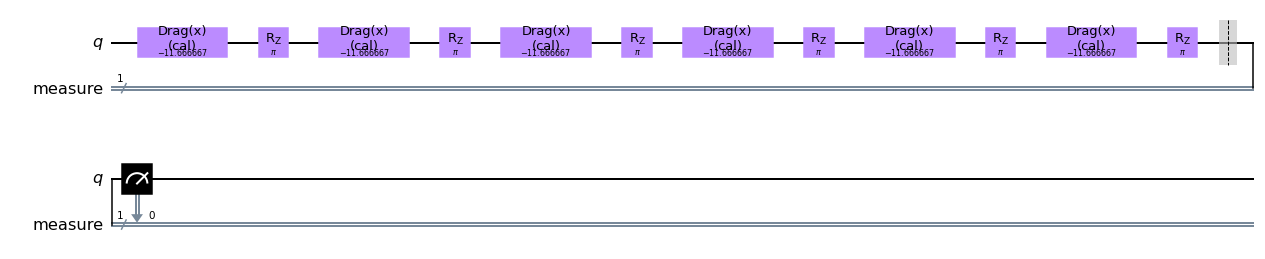

In [37]:
from qiskit_experiments.library import RoughDragCal
cal_drag = RoughDragCal(qubit, cals, backend=backend, betas=np.linspace(-20, 20, 25))
cal_drag.set_experiment_options(reps=[3, 5, 7])
cal_drag.circuits()[5].draw(output='mpl')

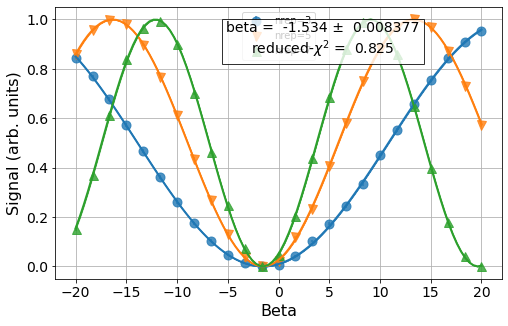

In [38]:
drag_data = cal_drag.run().block_for_results()
drag_data.figure(0)

In [39]:
print(drag_data.analysis_results("beta"))

AnalysisResult
- name: beta
- value: -1.534+/-0.008
- χ²: 0.8250491503588451
- quality: bad
- device_components: ['Q0']
- verified: False


In [40]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="β"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,β,(),sx,0.00000,default,True,2022-11-24 10:08:07.452283+0900,None
1,β,(),x,0.00000,default,True,2022-11-24 10:08:07.452283+0900,None
2,β,"(0,)",x,-1.53357,default,True,2022-11-24 10:16:01.766369+0900,7f57b2eb-6fc7-409e-b2d8-edfba41106bd


# Fine Amplitude

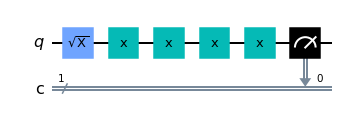

In [41]:
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitudeCal
amp_x_cal = FineXAmplitudeCal(qubit, cals, backend=backend, schedule_name="x")
amp_x_cal.circuits()[5].draw(output="mpl")

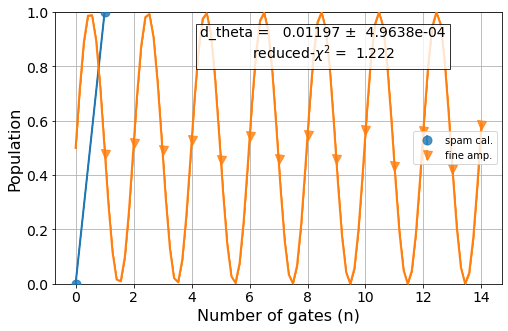

In [42]:
data_fine = amp_x_cal.run().block_for_results()
data_fine.figure(0)

In [43]:
print(data_fine.analysis_results("d_theta"))

AnalysisResult
- name: d_theta
- value: 0.0120+/-0.0005
- χ²: 1.2215050323386525
- quality: good
- device_components: ['Q0']
- verified: False


In [44]:
dtheta = data_fine.analysis_results("d_theta").value.nominal_value
target_angle = np.pi
scale = target_angle / (target_angle + dtheta)
pulse_amp = cals.get_parameter_value("amp", qubit, "x")
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.012 rad.
Thus, scale the 0.0291+0.0000j pulse amplitude by 0.996 to obtain 0.02899+0.00000j.


In [45]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,(),x,0.500000+0.000000j,default,True,2022-11-24 10:08:07.452085+0900,None
1,amp,"(0,)",sx,0.014604+0.000000j,default,True,2022-11-24 10:14:41.357339+0900,6edba754-60aa-42ff-b98d-ec2d11dd5652
2,amp,"(0,)",x,0.029097+0.000000j,default,True,2022-11-24 10:17:19.056238+0900,de94ece1-0c77-4a30-9e63-ea7703b16272
3,amp,(),sx,0.250000+0.000000j,default,True,2022-11-24 10:08:07.452283+0900,None


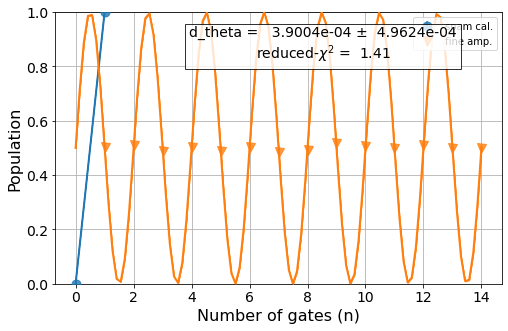

In [47]:
data_fine2 = amp_x_cal.run().block_for_results()
data_fine2.figure(0)

In [48]:
print(data_fine2.analysis_results("d_theta"))

AnalysisResult
- name: d_theta
- value: 0.0004+/-0.0005
- χ²: 1.4104459974914336
- quality: good
- device_components: ['Q0']
- verified: False
